In [3]:
# data analysis imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# import xgboost as xgb
# from xgboost import XGBClassifier

# preprocessing imports
import nltk
# nltk.download()
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import imblearn
from imblearn.over_sampling import SMOTE

# read the fake job postings dataset
df = pd.read_csv('fake_job_postings.csv')

In [4]:
# returns the first 5 rows
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
# describes the numerical features of our dataset
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# check for features where missing values are high
# note: we see that salary_range has significant number of NaN want to remove that, otherwise it will create noise
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
# check for duplicates
# no duplicates, so no need to handle them
df.duplicated().sum()

np.int64(0)

Counts:
 fraudulent
0    17014
1      866
Name: count, dtype: int64


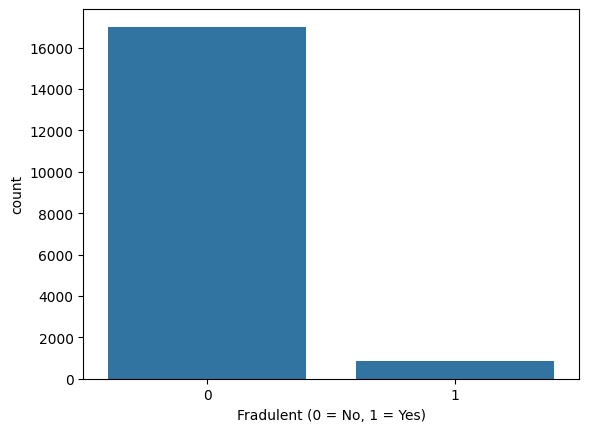

In [15]:
# plot bar chat for rows that are fraudulent
# dataset is imbalanced, will fix soon
sns.countplot(x='fraudulent', data=df)
counts = df['fraudulent'].value_counts()
x_label = "Fradulent (0 = No, 1 = Yes)"
plt.xlabel(x_label)

print("Counts:\n", counts)

In [10]:
# (look at df.isna().sum() code above for reference)
# drop job_id because it doesn't hold any value to our model, only serves a unique identifier
# drop salary_range because it has a significant amount of missing values(NaN) which can affect model performance and complicate preprocessing with its noise
columns = ['job_id', 'salary_range']

for col in columns:
    del df[col]

# Fill the 'NaN' fields in our dataset to avoid errors when dealing with TF-IDF or our models
df.fillna('unknown', inplace=True)
df.head()

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,unknown,0,1,0,Other,Internship,unknown,unknown,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,unknown,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,unknown,0,1,0,unknown,unknown,unknown,unknown,unknown,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [11]:
# generate stop words to clean our text
stop_words = set(stopwords.words('english'))

# add the punctuation list to the set of stop words
punctuation = list(string.punctuation)
stop_words.update(punctuation)

# initialize our lemmatizer
lemmatizer = WordNetLemmatizer()

In [12]:
# combine the columns/features for TF-IDF to predict fraudulent
df['text'] = df['title'] + " " + df['location'] + " " + df['department'] + " " + df['company_profile'] + " " + df['description'] + " " + df['requirements'] + " " + df['benefits'] + " " + df['employment_type'] + " " + df['required_experience'] + " " +df['required_education'] + " " + df['industry'] + " " + df['function']

# reduce dataset dimensionality 
del_column = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

# delete the columns/features
for col in del_column: 
    del df[col]

In [16]:
def preprocess_text(text):
    '''
    Uses stopwords and lemmatizing to clean the text
     
    Parameters
    ----------
    text: the combined text of all our features
    '''

    # tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words and non-alphabetic tokens and lemmantize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

    return ' '.join(tokens)

# apply preprocessing and add new ['text_processed] feature
df['text_processed'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text,text_processed
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We...",marketing intern u ny new york marketing creat...
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ...",customer service cloud video production nz auc...
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA...",commissioning machinery assistant cma u ia wev...
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash...",account executive washington dc u dc washingto...
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth unknown...",bill review manager u fl fort worth unknown sp...


In [17]:
# split into train/test sets using 20% for test
# trainX: the training features, textX: the test features | trainy: the labels, testy: the labels for the test data
trainX, testX, trainy, testy = train_test_split(df['text_processed'], df['fraudulent'], test_size = 0.2, random_state=0)

In [42]:
# report train set class distribution
print("Train set class distribution:\n", pd.Series(trainy).value_counts())
print("\nTrain set class ratio (Not Fraudulent/Total):", pd.Series(trainy).value_counts()[0] / len(trainy))
print("Train set class ratio (Fraudulent/Total):", pd.Series(trainy).value_counts()[1] / len(trainy))

Train set class distribution:
 fraudulent
0    13591
1      713
Name: count, dtype: int64

Train set class ratio (Not Fraudulent/Total): 0.950153803131991
Train set class ratio (Fraudulent/Total): 0.04984619686800895


In [41]:
# report test set class distribution
print("Test set class distribution:\n", pd.Series(testy).value_counts())
print("\nTest set class ratio (Not Fradulent/Total):", pd.Series(testy).value_counts()[0] / len(testy))
print("Test set class ratio (Fraudulent/Total):", pd.Series(testy).value_counts()[1] / len(testy))

Test set class distribution:
 fraudulent
0    3423
1     153
Name: count, dtype: int64

Test set class ratio (Not Fradulent/Total): 0.9572147651006712
Test set class ratio (Fraudulent/Total): 0.04278523489932886


In [24]:
# instantiate the vectorizer object
# min_df, max_df just includes all the text, already removed stopwords at preprocess
# ngram to pick up important phrases or patterns, (1,3) for like at most 3-words
tfidf_vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,3))
# convert the training set into a matrix.
tfidf_train = tfidf_vectorizer.fit_transform(trainX)
# convert the test set into a matrix.
tfidf_test = tfidf_vectorizer.transform(testX)

In [27]:
print(tfidf_train.shape)
print(tfidf_test.shape)

(14304, 2217449)
(3576, 2217449)


In [ ]:
# fix the imbalance issue with SMOTE
# tfidf_train is your numerical feature matrix (X) after converting text to TF-IDF vectors — this is what your model will actually learn from.
# trainy is your label vector (y) containing the class labels (fraudulent vs. not fraudulent).

oversample = SMOTE()
tfidf_train_resampled, trainy_resampled = oversample.fit_resample(tfidf_train, trainy)

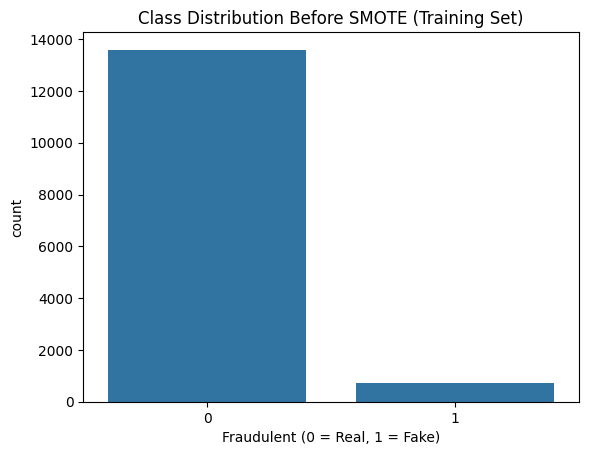

Before SMOTE:
 fraudulent
0    13591
1      713
Name: count, dtype: int64


In [38]:
sns.countplot(x=trainy)
plt.title("Class Distribution Before SMOTE (Training Set)")
plt.xlabel("Fraudulent (0 = Real, 1 = Fake)")
plt.show()
print("Before SMOTE:\n", pd.Series(trainy).value_counts())

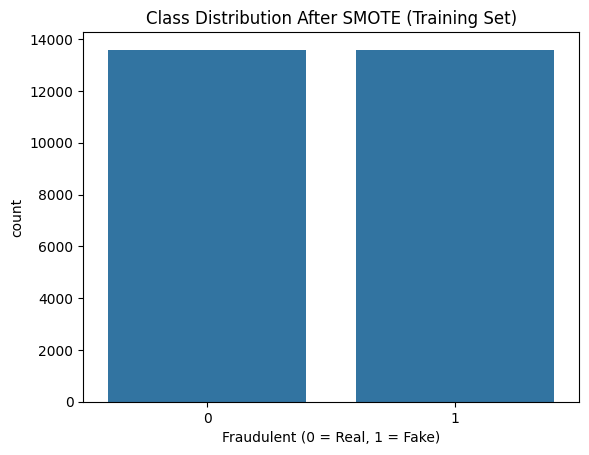

After SMOTE: fraudulent
0    13591
1    13591
Name: count, dtype: int64


In [ ]:
sns.countplot(x=trainy_resampled)
plt.title("Class Distribution After SMOTE (Training Set)")
plt.xlabel("Fraudulent (0 = Real, 1 = Fake)")
plt.show()
print("After SMOTE:\n", pd.Series(trainy_resampled).value_counts())

In [ ]:
# run logisitic regression on the training data
logreg = LogisticRegression(random_state=0).fit(tfidf_train_resampled, trainy_resampled)

In [ ]:
# use the trained Logistic Regression model (logreg) to predict labels for the unseen test data (tfidf_test), and store the predicted labels in predict_test.
predict_test = logreg.predict(tfidf_test)

In [ ]:
log_acc = accuracy_score(testy, predict_test)
log_prec = precision_score(testy, predict_test)
log_recall = recall_score(testy, predict_test)
log_f1 = f1_score(testy, predict_test)

# testy are the actual labels, predict_test are the predicted labels
print(f"Accuracy {accuracy_score(testy, predict_test)}")
print(f"Precision score {precision_score(testy, predict_test)}")
print(f"Recall score {recall_score(testy, predict_test)}")
print(f"F1 score {f1_score(testy, predict_test)}")

print(f"\nConfusion Matrix:\n", confusion_matrix(testy, predict_test))

Accuracy 0.9823825503355704
Precision score 0.774390243902439
Recall score 0.8300653594771242
F1 score 0.8012618296529969

Confusion Matrix:
 [[3386   37]
 [  26  127]]


In [ ]:
# Class 0: Non-fradulent, Class 1: Fradulent | 3423 non-fraud, 153 fraud in test data 
# precision, recall, and f1-score all 0.99, its fine because its the majority class
# precision: model predicts fraud for 78% of the time
# recall: model finds 84% of all actual frauds
# f1-score: the balance between precision and recall
result = classification_report(testy, predict_test)
print("Classification Report:")
print(result)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3423
           1       0.77      0.83      0.80       153

    accuracy                           0.98      3576
   macro avg       0.88      0.91      0.90      3576
weighted avg       0.98      0.98      0.98      3576



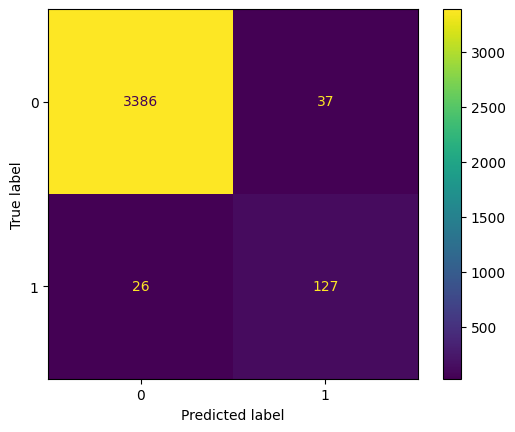

In [ ]:
# (TN) = 3386 - model correctly predicted non-fraudulent (0)
# (FP) = 37 - model incorrectly predicted fraudulent when it was not
# (FN) = 25 - model missed fraudulent cases (predicted 0 but was 1)
# (TP) = 128 - model correctly predicted fraudulent
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testy, predict_test, labels=logreg.classes_))
disp.plot()
plt.show()

In [ ]:

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# initialize xgboost
xgb_model = XGBClassifier(eval_metric='logloss')

# fit the model
# run on the training data
xgb_model.fit(tfidf_train_resampled, trainy_resampled)

# predict on the test set
y_pred = xgb_model.predict(tfidf_test)


In [ ]:
# accuracy
xgb_acc = accuracy_score(testy, y_pred)
xgb_prec = precision_score(testy, y_pred)
xgb_recall = recall_score(testy, y_pred)
xgb_f1 = f1_score(testy, y_pred)

print(f"XGBoost Accuracy: {xgb_acc:.4f}")

# classification report
print("Classification Report:")
print(classification_report(testy, y_pred))


XGBoost Accuracy: 0.9846
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3423
           1       0.90      0.72      0.80       153

    accuracy                           0.98      3576
   macro avg       0.94      0.86      0.90      3576
weighted avg       0.98      0.98      0.98      3576



In [ ]:
import numpy as np
importance = xgb_model.feature_importances_
nonzero_indices = np.where(importance > 0)[0]
top_features = sorted(zip(nonzero_indices, importance[nonzero_indices]),
                      key=lambda x: x[1], reverse=True)
feature_names = tfidf_vectorizer.get_feature_names_out()
top_feature_names = [feature_names[idx] for idx, _ in top_features[:10]]

print("Top 10 important words/features:") # doesn't suggest positive or negative, more about how much it help the model
print(top_feature_names)




Top 10 important words/features:
['encouraged', 'candidate encouraged', 'school equivalent', 'satisfaction', 'data entry', 'unknown unknown oil', 'secure', 'startup', 'amp insurance employee', 'exciting']


In [ ]:
logreg_coefficients = logreg.coef_[0]  # shape: (n_features,)
feature_names = tfidf_vectorizer.get_feature_names_out()

feature_coef_pairs = list(zip(feature_names, logreg_coefficients))

# Sort by largest positive weight
top_positive = sorted(feature_coef_pairs, key=lambda x: x[1], reverse=True)[:10]

# Sort by largest negative weights
top_negative = sorted(feature_coef_pairs, key=lambda x: x[1])[:10]

print("Top positive weights - predicting class 1 - fake:")
for feature, weight in top_positive:
    print(f"{feature}: {weight:.4f}")

print("\nTop negative weights - predicting class 0 - real:")
for feature, weight in top_negative:
    print(f"{feature}: {weight:.4f}")


Top positive weights - predicting class 1 - fake:
unknown unknown: 5.9815
administrative: 5.9006
unknown: 5.5459
data entry: 4.1765
entry: 4.1267
oil: 3.3840
assistant: 3.3644
earn: 3.2547
accion: 3.1927
phone: 2.7883

Top negative weights - predicting class 0 - real:
team: -3.2291
client: -3.2053
web: -2.7771
digital: -2.4853
software: -2.3894
medium: -2.3173
marketing: -2.1462
developer: -2.1167
website: -2.0983
mobile: -2.0727


In [ ]:
cls_models = [('Logistic Regression', log_acc, log_prec, log_recall,log_f1),('XGBoost', xgb_acc, xgb_prec, xgb_recall, xgb_f1),]

In [ ]:
# show table to compare models' efficiency
compare = pd.DataFrame(data = cls_models, columns=['Model', 'Accuracy', 'Precision' , 'Recall', 'F1'])
compare

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.982383,0.774390,0.830065,0.801262
1,XGBoost,0.984620,0.901639,0.718954,0.800000


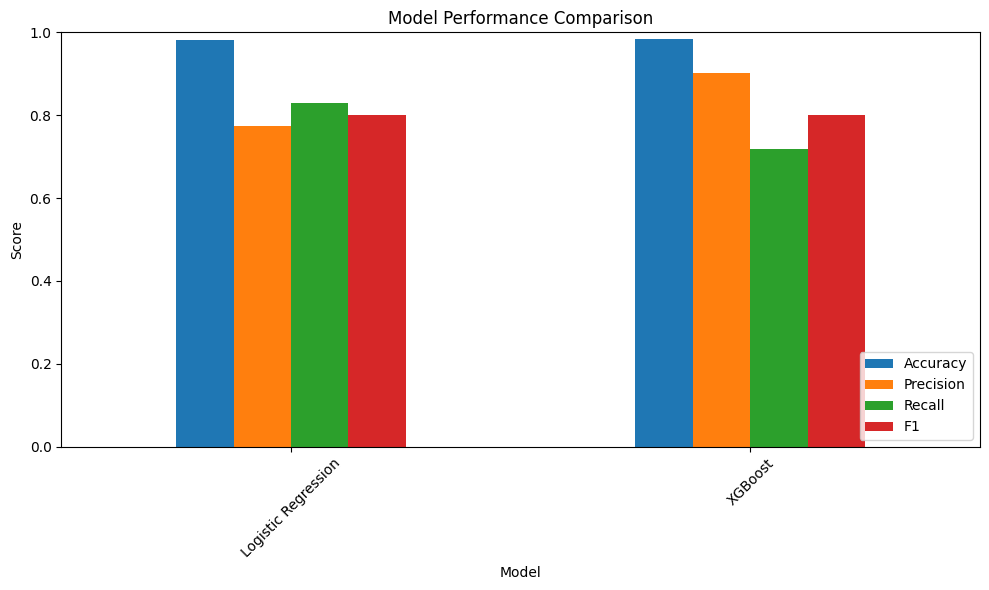

In [ ]:
# Plot the bar chart
compare.plot(kind='bar', figsize=(10, 6))

# Customize plot
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)  
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()